In [3]:
import pandas as pd

compressed_features = pd.read_excel("/content/compressed_features.xlsx")

In [4]:
compressed_features = compressed_features.dropna()

In [5]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(compressed_features)

# Divisive Clustering Function

In [6]:
def divisive_clustering_no_pca(X, max_depth=3, min_cluster_size=2000, sil_threshold=0.12):
    import numpy as np
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

    labels = np.zeros(X.shape[0], dtype=int)
    cluster_id = 0
    clusters_to_split = [(np.arange(X.shape[0]), 0, '')]
    logs = []

    while clusters_to_split:
        indices, depth, prefix = clusters_to_split.pop(0)
        X_subset = X[indices]

        if depth >= max_depth or len(indices) < min_cluster_size:
            labels[indices] = cluster_id
            cluster_id += 1
            logs.append(f"Depth {depth}, Prefix {prefix}, Size {len(indices)} - Stop splitting (max depth/min size reached)")
            continue

        kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
        sub_labels = kmeans.fit_predict(X_subset)

        sil_score = silhouette_score(X_subset, sub_labels)
        dbi_score = davies_bouldin_score(X_subset, sub_labels)
        ch_score = calinski_harabasz_score(X_subset, sub_labels)

        logs.append(
            f"Depth {depth}, Prefix {prefix}, Size {len(indices)}, "
            f"Silhouette: {sil_score:.4f}, DBI: {dbi_score:.4f}, CH: {ch_score:.2f}"
        )

        if sil_score >= sil_threshold:
            for subcluster_num in [0, 1]:
                sub_indices = indices[sub_labels == subcluster_num]
                sub_prefix = prefix + str(subcluster_num)
                clusters_to_split.append((sub_indices, depth + 1, sub_prefix))
        else:
            labels[indices] = cluster_id
            cluster_id += 1
            logs.append(f"Depth {depth}, Prefix {prefix}, Size {len(indices)} - Stop splitting (low silhouette)")

    return labels, logs


# Running Divisive on data

In [7]:
labels, logs = divisive_clustering_no_pca(X_scaled)
for log in logs:
    print(log)

Depth 0, Prefix , Size 99997, Silhouette: 0.1450, DBI: 2.1329, CH: 17423.86
Depth 1, Prefix 0, Size 51274, Silhouette: 0.1302, DBI: 2.3903, CH: 7917.00
Depth 1, Prefix 1, Size 48723, Silhouette: 0.7837, DBI: 0.3793, CH: 19585.85
Depth 2, Prefix 00, Size 26123, Silhouette: 0.1384, DBI: 2.2836, CH: 4341.15
Depth 2, Prefix 01, Size 25151, Silhouette: 0.1336, DBI: 2.3118, CH: 4225.43
Depth 2, Prefix 10, Size 48188, Silhouette: 0.1459, DBI: 2.2087, CH: 8841.56
Depth 2, Prefix 11, Size 535 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 000, Size 14943 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 001, Size 11180 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 010, Size 12638 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 011, Size 12513 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 100, Size 23450 - Stop splitting (max depth/min size reached)
Depth 3, Prefix 101, Size 24738 - Stop splitting (max depth/min size reache

### plotting the clusters

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


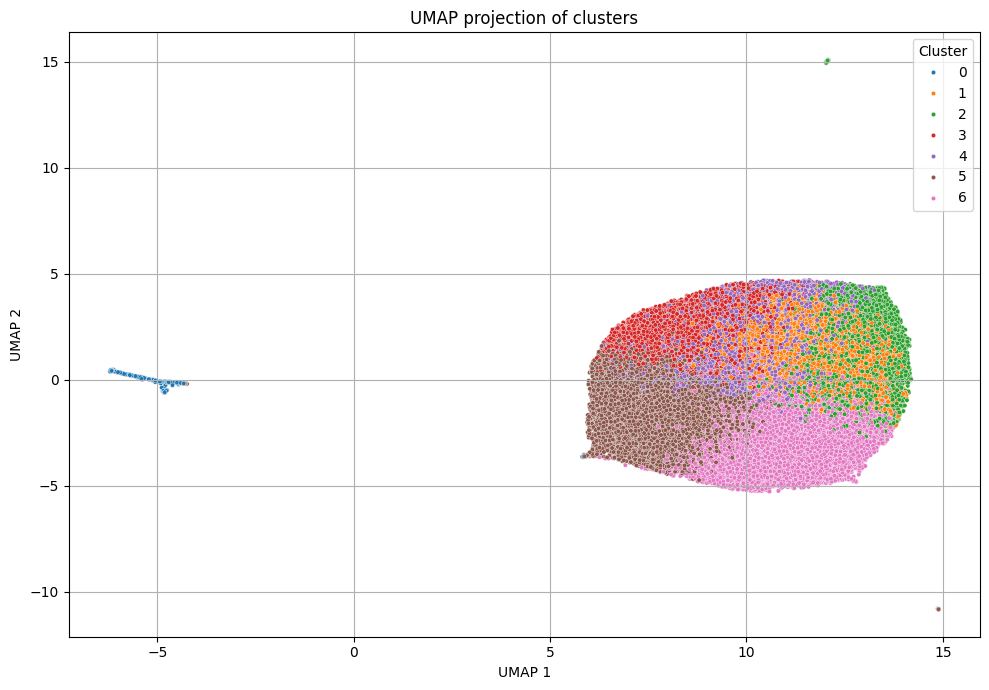

In [ ]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns

# dimention reduction to 2D
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette="tab10", s=10)
plt.title("UMAP projection of clusters")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()


### Extracting cluster profile for analysis

In [ ]:
df_clustered = pd.DataFrame(X_scaled, columns=["Lifestyle", "Interests", "Communication", "Responsibility", "SocialEngagement", "EmotionalStability", "Openness"])
df_clustered['cluster'] = labels
cluster_profiles = df_clustered.groupby('cluster').mean()

original_cluster_means = scaler.inverse_transform(cluster_profiles)

df_original_means = pd.DataFrame(original_cluster_means, columns=cluster_profiles.columns)
df_original_means.index.name = 'cluster'

print(df_original_means)


         Lifestyle  Interests  Communication  Responsibility  \
cluster                                                        
0         0.195093   0.676168       0.449065        0.182430   
1         3.673501   3.381132       3.243300        2.835843   
2         3.949284   3.604103       3.380602        3.353023   
3         3.164494   2.769752       3.214017        3.048774   
4         3.528960   2.952300       3.251988        3.485351   
5         3.184941   2.746461       2.879941        3.070593   
6         3.736620   3.338821       2.938935        2.874525   

         SocialEngagement  EmotionalStability  Openness  
cluster                                                  
0                0.458775            0.656075  0.462928  
1                3.473421            3.227576  2.719055  
2                3.395180            3.164908  3.223465  
3                3.565279            3.270362  2.993327  
4                3.412593            3.111964  3.481126  
5                

### تحلیل کلی خوشه‌ها بر اساس ویژگی‌ها
خوشه صفر:
مقدارهای خیلی پایین در همه‌ی ویژگی‌ها
(0.2, 0.7)
این خوشه به نظر می‌رسه شامل افرادی باشه با امتیازهای بسیار پایین در همه‌ی ابعاد: سبک زندگی، علاقه‌ها، مسئولیت‌پذیری، تعامل اجتماعی، ثبات هیجانی و باز بودن به تجربه. احتمالاً این افراد خیلی کم‌ارتباط، کمتر مسئول و به نوعی ناسازگارتر با بقیه هستند.


خوشه یک:
میانگین های حدود 3.2 تا 3.7 در اکثر ویژگی ها
این خوشه افراد متوسط رو به بالایی داره که در سبک زندگی، ارتباط و مسئولیت‌پذیری فعال‌تر و پایدارتر هستن ولی هنوز خیلی بالا نیستن. سطح باز بودن‌شون حدود 2.7 کمی پایین‌تر از بقیه‌ی ویژگی‌هاست.


خوشه دو:
بالاترین میانگین‌ها، تقریباً 3.3 تا 3.9 در اکثر ویژگی ها
این خوشه، احتمالاً بهترین و متعادل‌ترین گروهه. افراد این خوشه مسئول، باز، پایدار و اجتماعی هستند. می‌تونن کاندیدای مناسب‌تری برای هم‌اتاقی شدن باشن


خوشه سه:
میانگین های حدود 2.7 تا 3.5
شبیه خوشه ۱ و ۲ ولی کمی پایین‌تر در برخی ویژگی‌ها مثل علاقمندی‌ها و مسئولیت‌پذیری — این خوشه می‌تونه افرادی با سطح متوسط رو به پایین‌تر باشه، باز بودن نسبتاً خوب داره حدود 3


خوشه چهار:
شباهت زیادی به خوشه‌های 2 و 3 با کمی اختلاف
میانگین‌ها در حدود 2.9 تا 3.5، باز بودن بالاتر (3.48) و مسئولیت‌پذیری نسبتا خوب (3.48). این خوشه افراد نسبتاً باز و مسئول با سطح متوسط است


خوشه پنج:
سطح پایین‌تر در مسئولیت‌پذیری (2.87) و کمی پایین‌تر در ارتباط (2.88) و تعامل اجتماعی (2.75) نسبت به خوشه‌های 2 و 4 — ولی باز بودن نسبتا خوب (3.14). می‌تونه گروهی باشه با ثبات هیجانی کمتر و تعامل اجتماعی کمتر.


خوشه شش:
میانگین‌های مشابه خوشه 5 ولی کمی پایین‌تر در تعامل اجتماعی (2.57) و ثبات هیجانی (2.62) — باز بودن 2.92 که کمی پایین‌تره ولی باز هم متوسط است. احتمالاً گروهی با رفتار کمی محافظه‌کارتر و با ثبات هیجانی کمتر.

جمع بندی:


خوشه 0: گروه ناسازگار، کم‌فعال و کم‌ارتباط؛ احتمالاً این افراد به سختی با دیگران سازگار می‌شوند.

خوشه‌های 1، 3، 4، 5، 6: گروه‌های متوسط با تفاوت‌های جزئی؛ برخی بازتر و مسئول‌تر، برخی کمی محافظه‌کارتر یا کم‌تعامل‌تر.

خوشه 2: بهترین خوشه از نظر ویژگی‌ها، افراد مسئول، باز و اجتماعی. بهترین گزینه‌ها برای هم‌اتاقی.

# Trying to run Kernel Kmeans on subclusters

### Getting the two subxclusters

In [ ]:
labels_divisive, logs = divisive_clustering_no_pca(X_scaled, max_depth=1, sil_threshold=0.0)

import numpy as np
X_cluster0 = X_scaled[labels_divisive == 0]
X_cluster1 = X_scaled[labels_divisive == 1]

print("Cluster 0 size:", X_cluster0.shape[0])
print("Cluster 1 size:", X_cluster1.shape[0])


Cluster 0 size: 51274
Cluster 1 size: 48723


Kernel Kmeans with rbf didn't run

### Running RBFSampler on each subcluster

In [ ]:
from sklearn.kernel_approximation import RBFSampler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def kernel_kmeans_rbf_approx(X, n_clusters=3, gamma=0.1, n_components=100, random_state=42, plot=True):
    """
    Executes approximate Kernel KMeans using RBFSampler and KMeans on a given dataset X.

    Parameters:
        X (array-like): Input dataset (e.g., X_cluster0 or X_cluster1)
        n_clusters (int): Number of clusters for KMeans
        gamma (float): RBF kernel gamma value
        n_components (int): Number of components in RBF approximation
        random_state (int): Random seed for reproducibility
        plot (bool): Whether to plot the result using 2D PCA

    Returns:
        labels (np.ndarray): Cluster labels
        X_mapped (np.ndarray): Data in RBF-approximated space
        silhouette (float): Silhouette Score
    """

    # Step 1: Kernel Approximation
    rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
    X_mapped = rbf_feature.fit_transform(X)

    # Step 2: KMeans Clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    labels = kmeans.fit_predict(X_mapped)

    # Step 3: Evaluation
    silhouette = silhouette_score(X_mapped, labels)
    print(f"Silhouette Score: {silhouette:.4f}")

    # Step 4: Plotting (optional)
    if plot:
        pca = PCA(n_components=2)
        X_2d = pca.fit_transform(X_mapped)
        plt.figure(figsize=(6, 5))
        plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels, cmap='viridis', s=5)
        plt.title(f"RBF Approx + KMeans | Silhouette: {silhouette:.4f}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.tight_layout()
        plt.show()

    return labels, X_mapped, silhouette


Silhouette Score: 0.0925


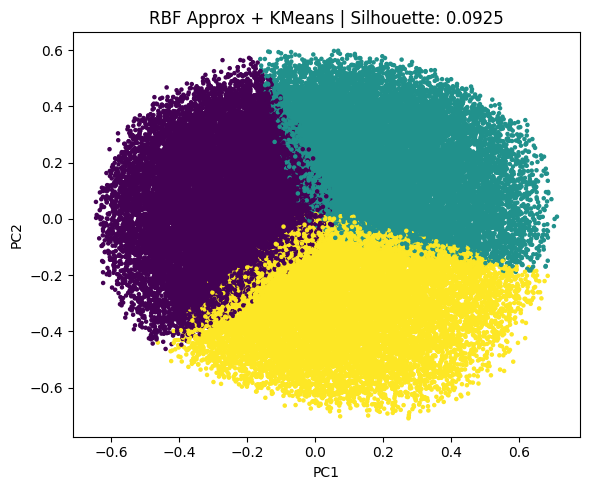

In [ ]:
labels0, mapped0, sil0 = kernel_kmeans_rbf_approx(X_cluster0, n_clusters=3, gamma=0.1)


Silhouette Score: 0.0964


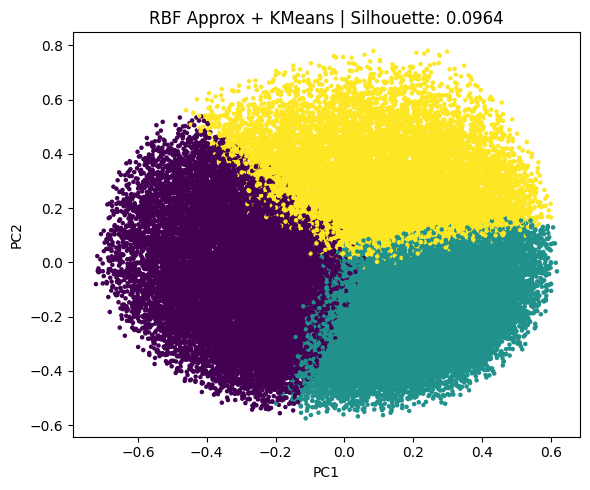

In [ ]:
labels1, mapped1, sil1 = kernel_kmeans_rbf_approx(X_cluster1, n_clusters=3, gamma=0.1)

### Trying to find the best gamma and number of clusters

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.kernel_approximation import RBFSampler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

def find_best_rbf_kernel_kmeans(X, gamma_list, k_list, n_components=100, random_state=42):
    results = []
    best_score = -1
    best_config = None

    for gamma in gamma_list:
        rbf_feature = RBFSampler(gamma=gamma, n_components=n_components, random_state=random_state)
        X_mapped = rbf_feature.fit_transform(X)

        for k in k_list:
            kmeans = KMeans(n_clusters=k, random_state=random_state)
            labels = kmeans.fit_predict(X_mapped)

            try:
                score = silhouette_score(X_mapped, labels)
            except:
                score = -1  # in case of degenerate clusters

            results.append((gamma, k, score))

            if score > best_score:
                best_score = score
                best_config = (gamma, k, labels, X_mapped)

            print(f"gamma={gamma}, k={k} → Silhouette={score:.4f}")

    # Visualize best
    gamma_best, k_best, labels_best, X_mapped_best = best_config
    pca = PCA(n_components=2)
    X_2d = pca.fit_transform(X_mapped_best)

    plt.figure(figsize=(6, 5))
    plt.scatter(X_2d[:, 0], X_2d[:, 1], c=labels_best, cmap='viridis', s=5)
    plt.title(f"Best Config: gamma={gamma_best}, k={k_best} → Silhouette={best_score:.4f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

    return {
        "best_gamma": gamma_best,
        "best_k": k_best,
        "best_score": best_score,
        "labels": labels_best,
        "X_mapped": X_mapped_best,
        "all_results": results
    }


gamma=0.01, k=2 → Silhouette=0.1462
gamma=0.01, k=3 → Silhouette=0.1297
gamma=0.01, k=4 → Silhouette=0.1218
gamma=0.01, k=5 → Silhouette=0.1078
gamma=0.05, k=2 → Silhouette=0.1207
gamma=0.05, k=3 → Silhouette=0.1124
gamma=0.05, k=4 → Silhouette=0.1085
gamma=0.05, k=5 → Silhouette=0.0986
gamma=0.1, k=2 → Silhouette=0.0965
gamma=0.1, k=3 → Silhouette=0.0925
gamma=0.1, k=4 → Silhouette=0.0897
gamma=0.1, k=5 → Silhouette=0.0858
gamma=0.2, k=2 → Silhouette=0.0687
gamma=0.2, k=3 → Silhouette=0.0659
gamma=0.2, k=4 → Silhouette=0.0634
gamma=0.2, k=5 → Silhouette=0.0628
gamma=0.5, k=2 → Silhouette=0.0315
gamma=0.5, k=3 → Silhouette=0.0295
gamma=0.5, k=4 → Silhouette=0.0269
gamma=0.5, k=5 → Silhouette=0.0278


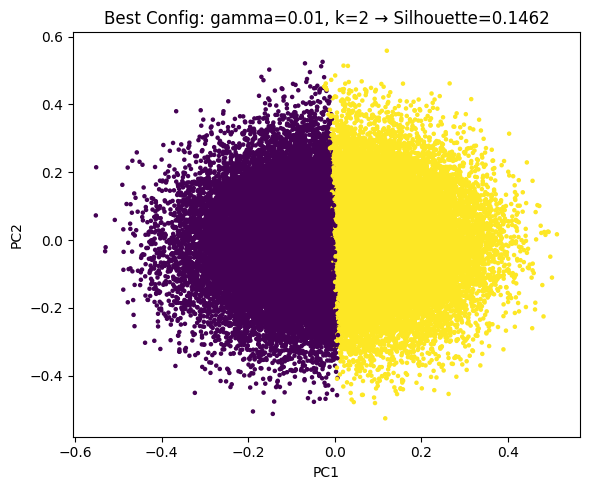

In [ ]:
gamma_values = [0.01, 0.05, 0.1, 0.2, 0.5]
cluster_counts = [2, 3, 4, 5]

result0 = find_best_rbf_kernel_kmeans(X_cluster0, gamma_values, cluster_counts)


gamma=0.01, k=2 → Silhouette=0.1549
gamma=0.01, k=3 → Silhouette=0.1390
gamma=0.01, k=4 → Silhouette=0.1437
gamma=0.01, k=5 → Silhouette=0.1185
gamma=0.05, k=2 → Silhouette=0.1340
gamma=0.05, k=3 → Silhouette=0.1206
gamma=0.05, k=4 → Silhouette=0.0974
gamma=0.05, k=5 → Silhouette=0.0917
gamma=0.1, k=2 → Silhouette=0.1094
gamma=0.1, k=3 → Silhouette=0.0964
gamma=0.1, k=4 → Silhouette=0.0852
gamma=0.1, k=5 → Silhouette=0.0799
gamma=0.2, k=2 → Silhouette=0.0757
gamma=0.2, k=3 → Silhouette=0.0660
gamma=0.2, k=4 → Silhouette=0.0598
gamma=0.2, k=5 → Silhouette=0.0570
gamma=0.5, k=2 → Silhouette=0.0335
gamma=0.5, k=3 → Silhouette=0.0286
gamma=0.5, k=4 → Silhouette=0.0235
gamma=0.5, k=5 → Silhouette=0.0259


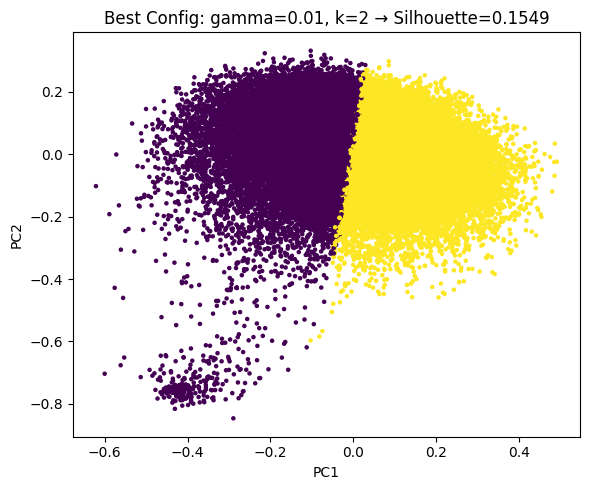

In [ ]:
gamma_values = [0.01, 0.05, 0.1, 0.2, 0.5]
cluster_counts = [2, 3, 4, 5]

result1 = find_best_rbf_kernel_kmeans(X_cluster1, gamma_values, cluster_counts)


### Running kernel kmeans on sub-subclusters

In [ ]:
labels = result0["labels"]

X0_sub0 = X_cluster0[labels == 0]
X0_sub1 = X_cluster0[labels == 1]

labels = result1["labels"]

X1_sub0 = X_cluster1[labels == 0]
X1_sub1 = X_cluster1[labels == 1]


gamma=0.01, k=2 → Silhouette=0.1378
gamma=0.01, k=3 → Silhouette=0.1180
gamma=0.01, k=4 → Silhouette=0.1111
gamma=0.01, k=5 → Silhouette=0.1040
gamma=0.05, k=2 → Silhouette=0.1216
gamma=0.05, k=3 → Silhouette=0.1069
gamma=0.05, k=4 → Silhouette=0.1014
gamma=0.05, k=5 → Silhouette=0.0889
gamma=0.1, k=2 → Silhouette=0.1104
gamma=0.1, k=3 → Silhouette=0.0922
gamma=0.1, k=4 → Silhouette=0.0882
gamma=0.1, k=5 → Silhouette=0.0843
gamma=0.2, k=2 → Silhouette=0.0823
gamma=0.2, k=3 → Silhouette=0.0699
gamma=0.2, k=4 → Silhouette=0.0669
gamma=0.2, k=5 → Silhouette=0.0645
gamma=0.5, k=2 → Silhouette=0.0405
gamma=0.5, k=3 → Silhouette=0.0315
gamma=0.5, k=4 → Silhouette=0.0324
gamma=0.5, k=5 → Silhouette=0.0323


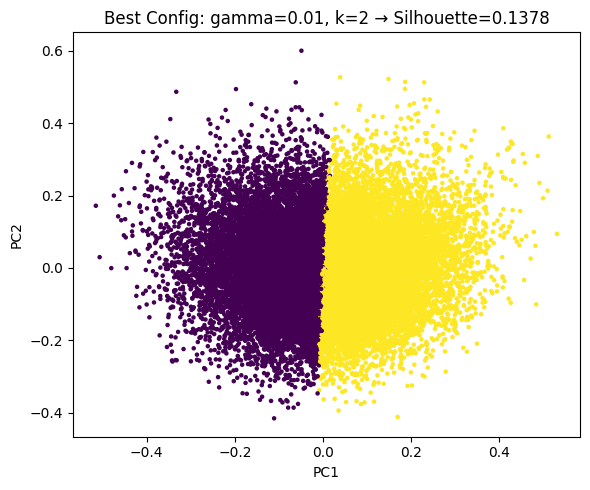

gamma=0.01, k=2 → Silhouette=0.1407
gamma=0.01, k=3 → Silhouette=0.1224
gamma=0.01, k=4 → Silhouette=0.1072
gamma=0.01, k=5 → Silhouette=0.1023
gamma=0.05, k=2 → Silhouette=0.1266
gamma=0.05, k=3 → Silhouette=0.1168
gamma=0.05, k=4 → Silhouette=0.0990
gamma=0.05, k=5 → Silhouette=0.0978
gamma=0.1, k=2 → Silhouette=0.1100
gamma=0.1, k=3 → Silhouette=0.1032
gamma=0.1, k=4 → Silhouette=0.0864
gamma=0.1, k=5 → Silhouette=0.0874
gamma=0.2, k=2 → Silhouette=0.0817
gamma=0.2, k=3 → Silhouette=0.0783
gamma=0.2, k=4 → Silhouette=0.0693
gamma=0.2, k=5 → Silhouette=0.0679
gamma=0.5, k=2 → Silhouette=0.0348
gamma=0.5, k=3 → Silhouette=0.0312
gamma=0.5, k=4 → Silhouette=0.0305
gamma=0.5, k=5 → Silhouette=0.0319


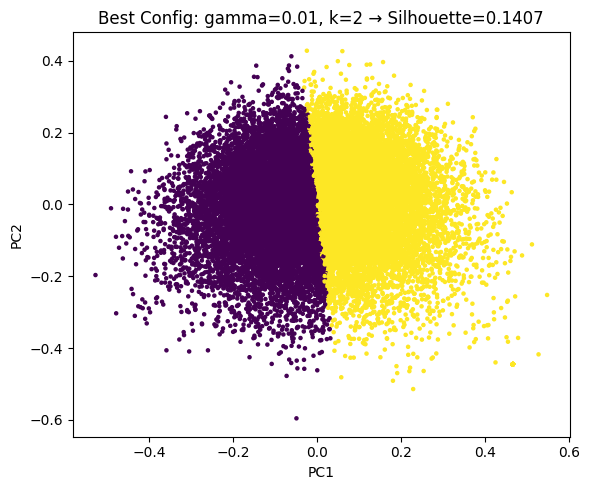

gamma=0.01, k=2 → Silhouette=0.6926
gamma=0.01, k=3 → Silhouette=0.1575
gamma=0.01, k=4 → Silhouette=0.1246
gamma=0.01, k=5 → Silhouette=0.1184
gamma=0.05, k=2 → Silhouette=0.1353
gamma=0.05, k=3 → Silhouette=0.0963
gamma=0.05, k=4 → Silhouette=0.1162
gamma=0.05, k=5 → Silhouette=0.1051
gamma=0.1, k=2 → Silhouette=0.1099
gamma=0.1, k=3 → Silhouette=0.0851
gamma=0.1, k=4 → Silhouette=0.0805
gamma=0.1, k=5 → Silhouette=0.0933
gamma=0.2, k=2 → Silhouette=0.0790
gamma=0.2, k=3 → Silhouette=0.0630
gamma=0.2, k=4 → Silhouette=0.0538
gamma=0.2, k=5 → Silhouette=0.0554
gamma=0.5, k=2 → Silhouette=0.0364
gamma=0.5, k=3 → Silhouette=0.0262
gamma=0.5, k=4 → Silhouette=0.0267
gamma=0.5, k=5 → Silhouette=0.0264


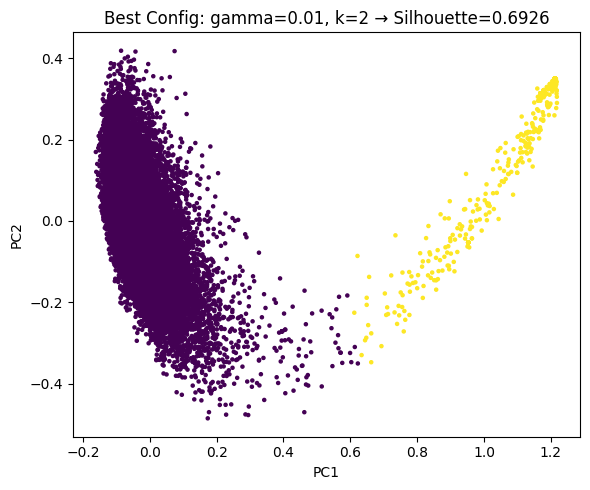

gamma=0.01, k=2 → Silhouette=0.1353
gamma=0.01, k=3 → Silhouette=0.1146
gamma=0.01, k=4 → Silhouette=0.1099
gamma=0.01, k=5 → Silhouette=0.1126
gamma=0.05, k=2 → Silhouette=0.1271
gamma=0.05, k=3 → Silhouette=0.1057
gamma=0.05, k=4 → Silhouette=0.1040
gamma=0.05, k=5 → Silhouette=0.0998
gamma=0.1, k=2 → Silhouette=0.1129
gamma=0.1, k=3 → Silhouette=0.0954
gamma=0.1, k=4 → Silhouette=0.0950
gamma=0.1, k=5 → Silhouette=0.0884
gamma=0.2, k=2 → Silhouette=0.0841
gamma=0.2, k=3 → Silhouette=0.0732
gamma=0.2, k=4 → Silhouette=0.0679
gamma=0.2, k=5 → Silhouette=0.0641
gamma=0.5, k=2 → Silhouette=0.0382
gamma=0.5, k=3 → Silhouette=0.0317
gamma=0.5, k=4 → Silhouette=0.0319
gamma=0.5, k=5 → Silhouette=0.0347


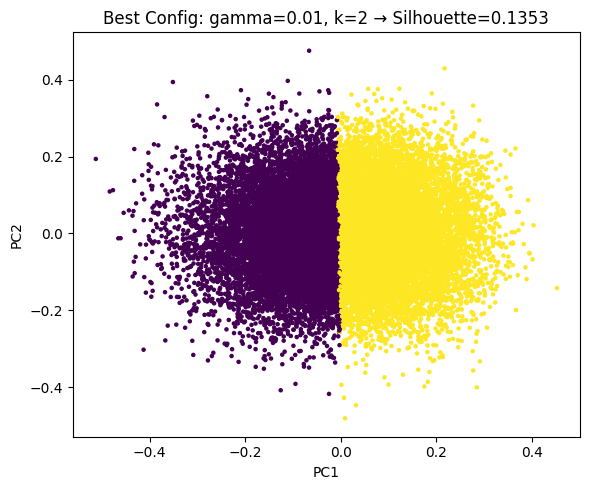

In [ ]:
gamma_values = [0.01, 0.05, 0.1, 0.2, 0.5]
cluster_counts = [2, 3, 4, 5]

res_0_0 = find_best_rbf_kernel_kmeans(X0_sub0, gamma_values, cluster_counts)
res_0_1 = find_best_rbf_kernel_kmeans(X0_sub1, gamma_values, cluster_counts)
res_1_0 = find_best_rbf_kernel_kmeans(X1_sub0, gamma_values, cluster_counts)
res_1_1 = find_best_rbf_kernel_kmeans(X1_sub1, gamma_values, cluster_counts)


### تفسير هشت خوشه به دست آمده

📊 Cluster Feature Averages (8 clusters):


,Lifestyle,Interests,Communication,Responsibility,SocialEngagement,EmotionalStability,Openness
000,3.215888,2.839518,3.143183,3.173861,3.483578,3.433396,3.018465
001,3.562101,3.075634,3.153977,3.462028,3.585612,3.121503,3.471384
010,3.624219,3.298459,3.361252,2.845305,3.369257,3.279748,2.671249
011,3.888091,3.481906,3.412425,3.159765,3.419554,2.950809,3.172227
100,3.223351,2.814236,2.769882,3.105784,2.774197,2.731911,3.146755
101,0.178640,0.634818,0.411159,0.163218,0.428267,0.613665,0.431034
110,3.588584,3.232604,3.013746,2.734759,2.568048,2.707381,2.625624
111,3.771689,3.285463,3.053410,2.951344,2.552861,2.453689,3.207226


<Figure size 1400x600 with 0 Axes>

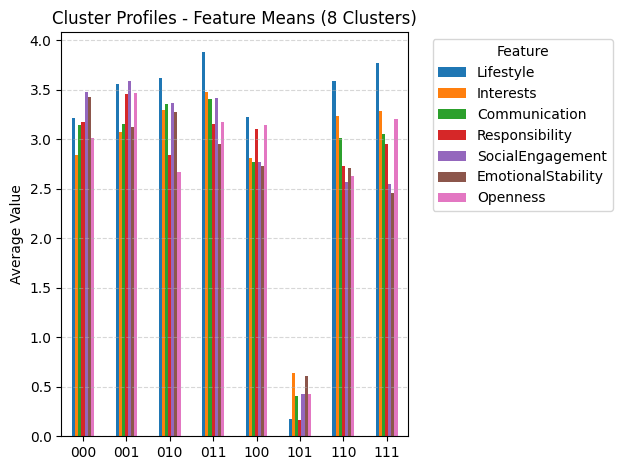

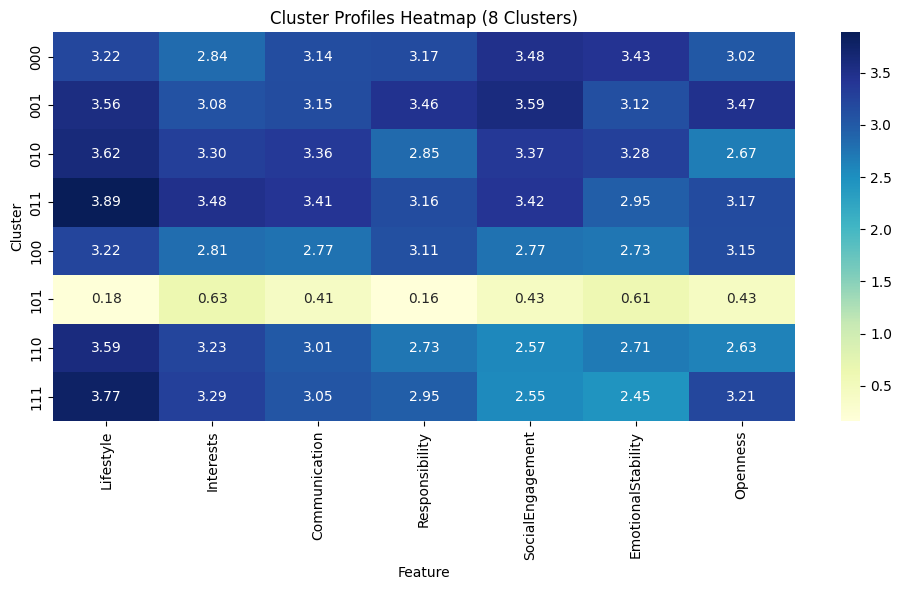

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

idx_cluster0 = np.where(labels_divisive == 0)[0]
idx_cluster1 = np.where(labels_divisive == 1)[0]

labels_0 = result0["labels"]
labels_1 = result1["labels"]

idxs_00 = idx_cluster0[labels_0 == 0]
idxs_01 = idx_cluster0[labels_0 == 1]
idxs_10 = idx_cluster1[labels_1 == 0]
idxs_11 = idx_cluster1[labels_1 == 1]

labels_00 = res_0_0["labels"]
labels_01 = res_0_1["labels"]
labels_10 = res_1_0["labels"]
labels_11 = res_1_1["labels"]

idxs_000 = idxs_00[labels_00 == 0]
idxs_001 = idxs_00[labels_00 == 1]

idxs_010 = idxs_01[labels_01 == 0]
idxs_011 = idxs_01[labels_01 == 1]

idxs_100 = idxs_10[labels_10 == 0]
idxs_101 = idxs_10[labels_10 == 1]

idxs_110 = idxs_11[labels_11 == 0]
idxs_111 = idxs_11[labels_11 == 1]

feature_columns = ['Lifestyle', 'Interests', 'Communication', 'Responsibility',
                   'SocialEngagement', 'EmotionalStability', 'Openness']

X_000 = compressed_features.loc[idxs_000, feature_columns]
X_001 = compressed_features.loc[idxs_001, feature_columns]
X_010 = compressed_features.loc[idxs_010, feature_columns]
X_011 = compressed_features.loc[idxs_011, feature_columns]
X_100 = compressed_features.loc[idxs_100, feature_columns]
X_101 = compressed_features.loc[idxs_101, feature_columns]
X_110 = compressed_features.loc[idxs_110, feature_columns]
X_111 = compressed_features.loc[idxs_111, feature_columns]

cluster_profiles_8 = pd.DataFrame({
    '000': X_000.mean(),
    '001': X_001.mean(),
    '010': X_010.mean(),
    '011': X_011.mean(),
    '100': X_100.mean(),
    '101': X_101.mean(),
    '110': X_110.mean(),
    '111': X_111.mean(),
}).T

print("📊 Cluster Feature Averages (8 clusters):")
display(cluster_profiles_8)

plt.figure(figsize=(14, 6))
cluster_profiles_8.plot(kind='bar')
plt.title("Cluster Profiles - Feature Means (8 Clusters)")
plt.ylabel("Average Value")
plt.xticks(rotation=0)
plt.legend(title="Feature", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.heatmap(cluster_profiles_8, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Cluster Profiles Heatmap (8 Clusters)")
plt.xlabel("Feature")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()


# Compatibility Score

## Comparing different weights

=== Weights: cos=0.5, clu=0.5 ===
count    499985.000000
mean          3.707027
std           0.640414
min           0.035190
25%           3.928233
50%           3.948076
75%           3.962397
max           4.000000
Name: score_0_4, dtype: float64 

=== Weights: cos=0.7, clu=0.3 ===
count    499985.000000
mean          3.784053
std           0.387831
min           1.511315
25%           3.899527
50%           3.927306
75%           3.947356
max           4.000000
Name: score_0_4, dtype: float64 

=== Weights: cos=0.9, clu=0.1 ===
count    499985.000000
mean          3.861079
std           0.138238
min           2.980917
25%           3.870853
50%           3.906536
75%           3.932314
max           4.000000
Name: score_0_4, dtype: float64 



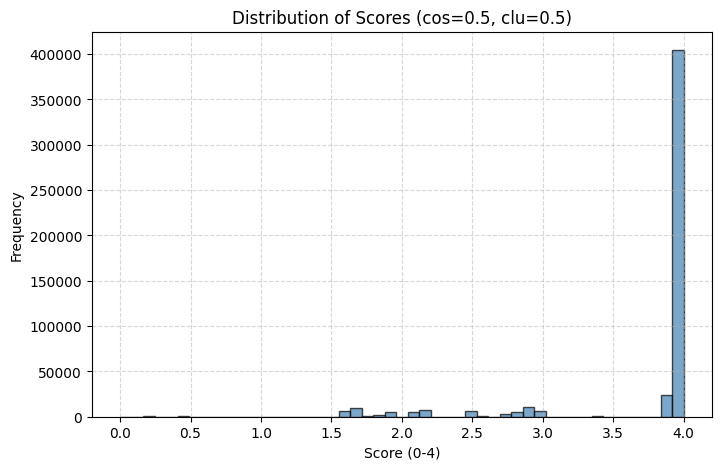

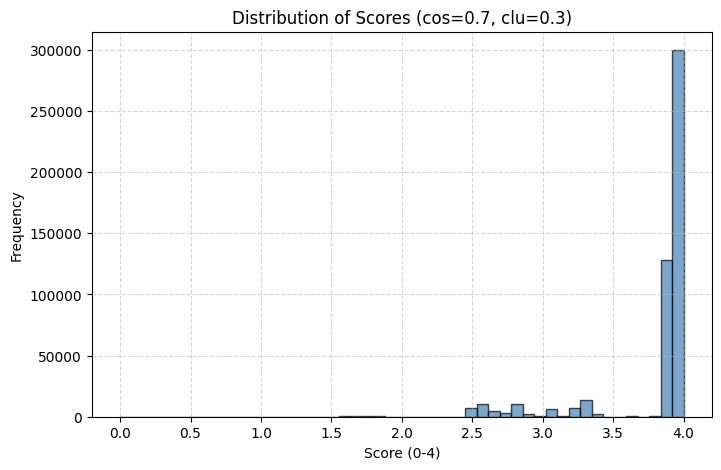

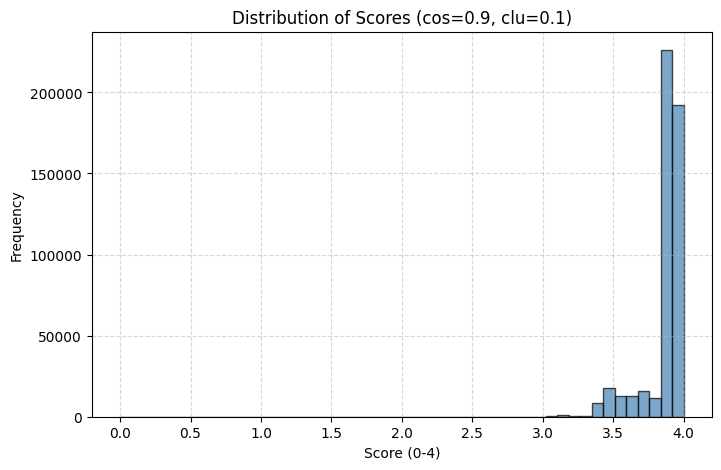

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity

X = X_scaled
labels = labels  # from divisive clustering
k = 5

unique_clusters = np.unique(labels)
centroids = np.vstack([X[labels == c].mean(axis=0) for c in unique_clusters])
centroid_sim = cosine_similarity(centroids)
cluster_to_idx = {c: i for i, c in enumerate(unique_clusters)}

def cluster_score(ci, cj):
    ii = cluster_to_idx[ci]
    jj = cluster_to_idx[cj]
    return centroid_sim[ii, jj]

nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(X)
distances, indices = nn.kneighbors(X, n_neighbors=k+1)

def evaluate_weights(w_cos, w_clu):
    all_matches = []

    for i in range(X.shape[0]):
        nbrs = indices[i][1:]
        dists = distances[i][1:]
        sims  = 1.0 - dists
        cs = np.array([cluster_score(labels[i], labels[j]) for j in nbrs])

        raw = w_cos * sims + w_clu * cs
        scores = 4.0 * raw
        order = np.argsort(-scores)

        for nbr, sc in zip(nbrs[order], scores[order]):
            all_matches.append({
                'user_id': i,
                'candidate_id': nbr,
                'score_0_4': sc
            })

    df = pd.DataFrame(all_matches)

    desc = df['score_0_4'].describe()

    return df, desc

weights = [(0.5,0.5), (0.7,0.3), (0.9,0.1)]
results = {}
dfs = {}

for w_cos, w_clu in weights:
    df, desc = evaluate_weights(w_cos, w_clu)
    dfs[(w_cos, w_clu)] = df
    results[(w_cos,w_clu)] = desc
    print(f"=== Weights: cos={w_cos}, clu={w_clu} ===")
    print(desc, "\n")

bins = np.linspace(0, 4, 50)

for (w_cos, w_clu), df in dfs.items():
    plt.figure(figsize=(8,5))
    plt.hist(df['score_0_4'], bins=bins, alpha=0.7, color="steelblue", edgecolor="black")
    plt.xlabel("Score (0-4)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution of Scores (cos={w_cos}, clu={w_clu})")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()



## Continueing with (0.3, 0.7)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity


X = X_scaled
labels = labels  # from divisive clustering
k = 5

# weights
w_cos, w_clu = 0.7, 0.3

unique_clusters = np.unique(labels)
centroids = np.vstack([X[labels == c].mean(axis=0) for c in unique_clusters])
centroid_sim = cosine_similarity(centroids)  # [0,1]

cluster_to_idx = {c: i for i, c in enumerate(unique_clusters)}

def cluster_score(ci, cj):
    ii = cluster_to_idx[ci]
    jj = cluster_to_idx[cj]
    return centroid_sim[ii, jj]

nn = NearestNeighbors(metric='cosine', algorithm='brute')
nn.fit(X)
distances, indices = nn.kneighbors(X, n_neighbors=k+1)

topk_scores = {}
topk_breakdown = {}

for i in range(X.shape[0]):
    nbrs = indices[i][1:]
    dists = distances[i][1:]
    sims  = 1.0 - dists
    cs = np.array([cluster_score(labels[i], labels[j]) for j in nbrs])

    raw = w_cos * sims + w_clu * cs
    scores = 4.0 * raw
    order = np.argsort(-scores)

    topk_scores[i] = list(zip(nbrs[order], scores[order]))
    topk_breakdown[i] = {
        'neighbor_ids': nbrs[order],
        'cosine_sim': sims[order],
        'cluster_score': cs[order],
        'final_score_0_4': scores[order],
    }


user_id = 0  # example
df_example = pd.DataFrame({
    'candidate_id': [u for u,_ in topk_scores[user_id]],
    'score_0_4': [s for _,s in topk_scores[user_id]],
    'cosine_sim': topk_breakdown[user_id]['cosine_sim'],
    'cluster_score': topk_breakdown[user_id]['cluster_score']
})
print(df_example)

all_matches = []
for i in range(X.shape[0]):
    for nbr, score in topk_scores[i]:
        all_matches.append({
            'user_id': i,
            'candidate_id': nbr,
            'score_0_4': score,
            'cosine_sim': topk_breakdown[i]['cosine_sim'][np.where(topk_breakdown[i]['neighbor_ids']==nbr)[0][0]],
            'cluster_score': topk_breakdown[i]['cluster_score'][np.where(topk_breakdown[i]['neighbor_ids']==nbr)[0][0]],
        })

df_all = pd.DataFrame(all_matches)
df_all.head()


   candidate_id  score_0_4  cosine_sim  cluster_score
0         29871   3.949230    0.981868            1.0
1         53498   3.944606    0.980217            1.0
2         43658   3.935046    0.976802            1.0
3         19494   3.934959    0.976771            1.0
4         50457   3.932156    0.975770            1.0


,user_id,candidate_id,score_0_4,cosine_sim,cluster_score
0,0,29871,3.949230,0.981868,1.0
1,0,53498,3.944606,0.980217,1.0
2,0,43658,3.935046,0.976802,1.0
3,0,19494,3.934959,0.976771,1.0
4,0,50457,3.932156,0.975770,1.0


In [ ]:
# Saving file to excel
df_all.to_excel("top5_matches.xlsx", index=False)


خروجی در فایل top5_matches.xlsx ذخیره شد.


## Analyzing

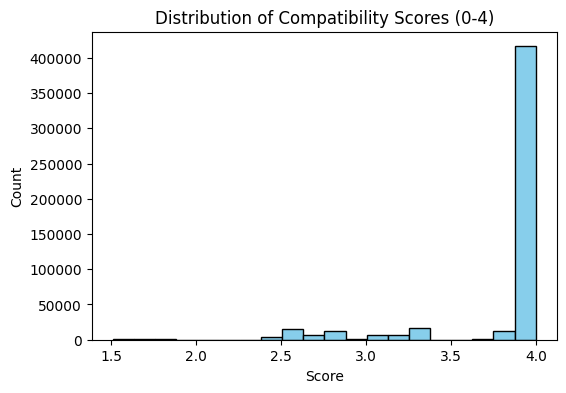

نمره‌ها (0..4):
count    499985.000000
mean          3.784053
std           0.387831
min           1.511315
25%           3.899527
50%           3.927306
75%           3.947356
max           4.000000
Name: score_0_4, dtype: float64


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.hist(df_all['score_0_4'], bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Compatibility Scores (0-4)")
plt.xlabel("Score")
plt.ylabel("Count")
plt.show()

print("scores (0..4):")
print(df_all['score_0_4'].describe())


## Finding people with less than 2.5 score

In [ ]:
import pandas as pd
import numpy as np

mean_top5_scores = np.array([np.mean([s for _, s in topk_scores[i]]) for i in range(len(topk_scores))])

# finding people with less than 2.5 mean
threshold = 2.5
low_score_idx = np.where(mean_top5_scores < threshold)[0]
print(f"numebr of people with mean < {threshold}: {len(low_score_idx)}")

low_score_clusters = labels[low_score_idx]
cluster_counts = pd.Series(low_score_clusters).value_counts()
print("number of people with low score in each cluster:")
print(cluster_counts)

mean_features_low_score = X[low_score_idx].mean(axis=0)
print("average of features between people with low score:")
print(mean_features_low_score)

df_low_score = pd.DataFrame({
    'user_id': low_score_idx,
    'cluster': low_score_clusters,
    'mean_top5_score': mean_top5_scores[low_score_idx]
})

df_low_score.head(10)


numebr of people with mean < 2.5: 133
number of people with low score in each cluster:
6    51
4    36
5    20
3    11
1    11
2     4
Name: count, dtype: int64
average of features between people with low score:
[ 0.06196621  0.08127424  0.16286445 -0.09273288 -0.00671707 -0.21157165
  0.21556955]


,user_id,cluster,mean_top5_score
0,320,3,2.477670
1,599,6,2.483773
2,1140,6,2.417694
3,1141,5,2.298902
4,1294,6,2.487617
5,2336,6,2.462612
6,2980,4,2.439504
7,3844,3,2.358144
8,5183,5,2.363065
9,5511,5,2.335353


## Getting matches for users with id

In [ ]:
def show_top5_for_user(user_id):
    if user_id not in topk_scores:
        print(f"user {user_id} does not exist.")
        return
    df = pd.DataFrame({
        'candidate_id': [u for u,_ in topk_scores[user_id]],
        'score_0_4': [s for _,s in topk_scores[user_id]],
        'cosine_sim': topk_breakdown[user_id]['cosine_sim'],
        'cluster_score': topk_breakdown[user_id]['cluster_score']
    })
    print(df)


In [ ]:
show_top5_for_user(2407)

   candidate_id  score_0_4  cosine_sim  cluster_score
0         50532        4.0         1.0            1.0
1         82534        4.0         1.0            1.0
2         61415        4.0         1.0            1.0
3         67611        4.0         1.0            1.0
4         95621        4.0         1.0            1.0
